# Generate figures for ICSME paper

In [2]:
from dotenv import find_dotenv, load_dotenv
from langchain_community.cache import SQLiteCache, RedisCache, InMemoryCache
from langchain_core.documents import Document
from langchain_core.globals import set_llm_cache
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableConfig,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_openai import ChatOpenAI
from langfuse.callback import CallbackHandler

load_dotenv(find_dotenv())

set_llm_cache(InMemoryCache())

In [3]:
from compose2kube.benchmark.benchmark import INPUTS_JUDGES, chains_convert_grade
from compose2kube.llm import GPT4_0125, GPT4_0409, GPT4_0613, GPT35TURBO, GPT4o_0513
from compose2kube.model import ChatOpenAIMultiGenerations

In [4]:
FINAL = True
GRADER_MODEL = GPT35TURBO
if FINAL:
    MODELS = [GPT35TURBO, GPT4_0613, GPT4_0409, GPT4o_0513]
    # GRADER_MODEL = GPT4_0125
    N = 50
else:
    MODELS = [GPT4o_0513]
    # MODELS = [GPT35TURBO, GPT4_0409, GPT4_0613]
    # MODELS = [GPT35TURBO]
    N = 20

chain = chains_convert_grade
names = [name for name, input, judge in INPUTS_JUDGES]
inputs = [{"compose": input, "judge": judge} for name, input, judge in INPUTS_JUDGES]

chains_per_model = RunnableParallel(
    {
        k: chain.with_config(
            RunnableConfig(
                configurable={
                    "model_name": k,
                    "grader_model_name": GRADER_MODEL,
                }
            )
        )
        for k in MODELS
    }
)

invoke

In [4]:
print("Is final?", FINAL is True)

from sqlite3 import IntegrityError
from tqdm import tqdm

for i in tqdm(range(5)):
    try:
        got = chains_per_model.map().invoke(
            inputs,
            config=RunnableConfig(
                configurable={"n": N},
                run_name="convert-grade",
                # callbacks=[CallbackHandler()],
            ),
        )
        acc = list(zip(names, got))
        del got
    except IntegrityError as e:
        # IntegrityError: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
        # then retry
        print(e)
        continue
    break

Is final? True


  0%|          | 0/5 [00:00<?, ?it/s]/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/pydantic/v1/main.py:996: RuntimeWarning: fields may not start with an underscore, ignoring "_in_out_pairs"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: 'str' object has no attribute 'get'
Error parsing YAML: mapping values are not allowed here
  in "<unicode string>", line 9, column 11:
      selector:
              ^
Error parsing YAML: mapping values are not allowed here
  in "<unicode string>", line 17, column 11:
      selector:
              ^
Error parsing YAML: mapping values are not allowed here
  in "<unicode string>", line 9, column 11:
      selector:
              ^


  0%|          | 0/5 [22:35<?, ?it/s]


## save/restore state

In [5]:
# import dill

# accfile = "20240517_acc.pkl"
# with open(accfile, "wb") as f:
#     dill.dump(acc, f)
#     print(f"wrote: {accfile}")

wrote: 20240517_acc.pkl


In [9]:
# import dill

# accfile = "20240517_acc.pkl"
# with open(accfile, "rb") as f:
#     acc = dill.load(f)
#     print(f"wrote: {accfile}")

wrote: 20240517_acc.pkl


## Eval1: Groundness

In [111]:
import pandas as pd

# modelに評価させる
_records = []
for input, _acc in acc:
    for model_name, __acc in _acc.items():
        for meth, dic in __acc.items():
            grades = dic["grade_by_model"]["model_graded"]
            _records.extend(
                [
                    dict(input=input, model_name=model_name, method=meth, grade=grade)
                    for grade in grades
                ]
            )

df = pd.DataFrame(_records)
df_merge = pd.concat([df.drop("grade", axis=1), df.grade.apply(pd.Series)], axis=1)
df_merge = df_merge.assign(decision=df_merge.decision == "Y")

表

In [112]:
_df = df_merge.groupby(["input", "model_name", "method"]).sum()
_df

decision  \
input   model_name             method                           
input12 gpt-3.5-turbo          expertprompting_json        49   
                               expertprompting_text        50   
                               zeroshot_jsonmode           50   
                               zeroshot_txt                50   
        gpt-4-0613             expertprompting_json        48   
...                                                       ...   
input9  gpt-4-turbo-2024-04-09 zeroshot_txt                50   
        gpt-4o-2024-05-13      expertprompting_json        50   
                               expertprompting_text        48   
                               zeroshot_jsonmode           50   
                               zeroshot_txt                46   

                                                                                           explanation  
input   model_name             method                                                                   
input12 gpt-3.5-turbo          expertprompting_json  The Kubernetes manifest is correctly converted...  
                               expertprompting_text  The Kubernetes manifest is correctly converted...  
                               zeroshot_jsonmode     The Kubernetes manifest is correctly converted...  
                               zeroshot_txt          The Kubernetes manifests are correctly convert...  
        gpt-4-0613             expertprompting_json  The Kubernetes manifests are correctly convert...  
...                                                                                                ...  
input9  gpt-4-turbo-2024-04-09 zeroshot_txt          The Kubernetes manifests are correctly convert...  
        gpt-4o-2024-05-13      expertprompting_json  The Kubernetes manifests are correctly convert...  
                               expertprompting_text  The Kubernetes manifests are correctly convert...  
                               zeroshot_jsonmode     The Kubernetes manifests are correctly convert...  
                               zeroshot_txt          The Kubernetes manifests are correctly convert...  

[80 rows x 2 columns]

図

/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


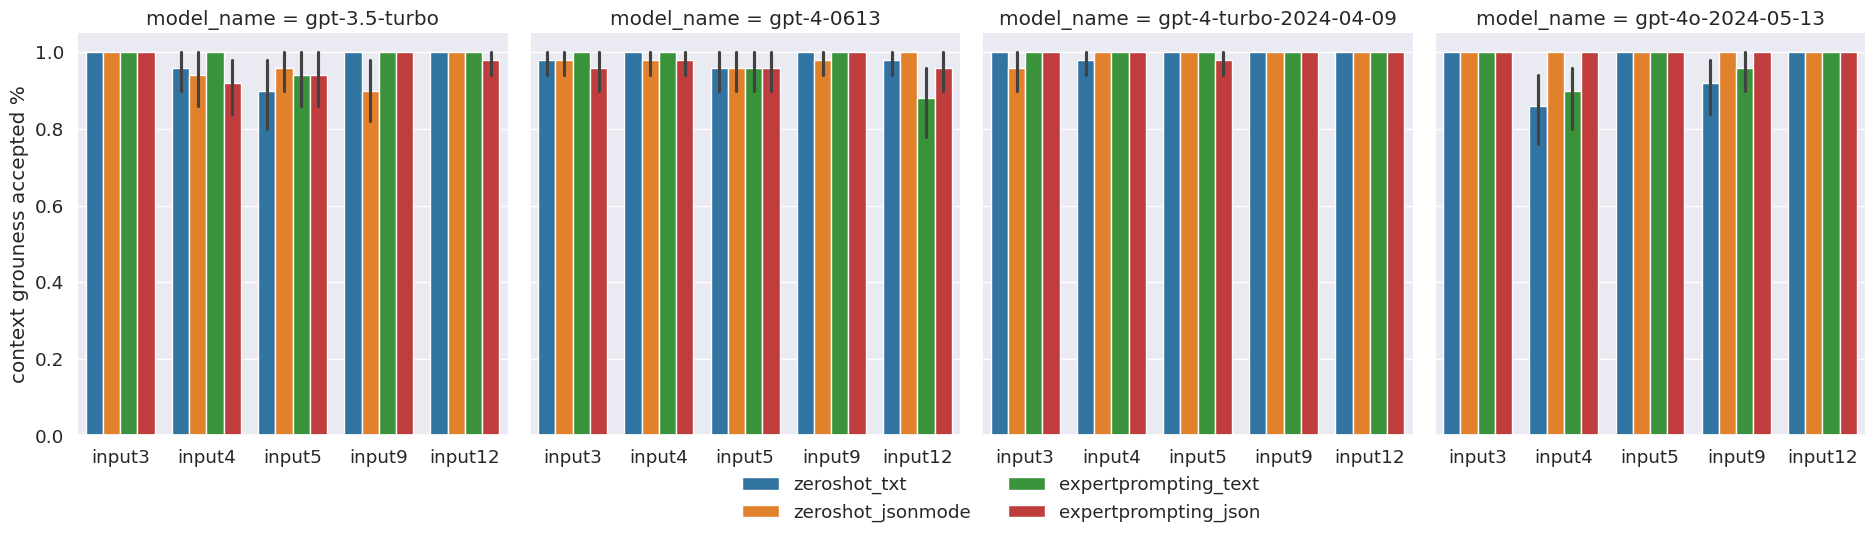

In [116]:
import seaborn as sns
import warnings


def plot_data(
    data,
    plotting_func,
    x,
    y,
    hue,
    main_title,
    x_label,
    y_label,
    col_name=None,
    row_name=None,
    plot_kwargs={},
    facet_kwargs={},
    palette="tab10",
    final=False,
    margin_titles=True,
):
    # sns.set_theme(style="whitegrid", font_scale=1)
    g = sns.FacetGrid(
        data,
        col=col_name,
        row=row_name,
        height=5,
        margin_titles=margin_titles,
        **facet_kwargs,
    )
    with warnings.catch_warnings():
        if final:
            warnings.simplefilter("ignore")
        g.map(
            plotting_func,
            x,
            y,
            hue,
            palette=palette,
            **plot_kwargs,
            # hue_order=hue_order,
            # errorbar=None,
        )

    # g.add_legend(title=hue, loc="lower center", bbox_to_anchor=(.4, -.15), frameon=False, ncol=2)
    g.add_legend(loc="lower center", bbox_to_anchor=(.4, -.1), frameon=False, ncol=2)
    g.figure.subplots_adjust(top=0.875)
    # g.figure.suptitle(main_title)
    g.set_axis_labels(x_label, y_label)
    return g.tight_layout()


plot_data(
    df_merge,
    col_name="model_name",
    plotting_func=sns.barplot,
    x="input",
    y="decision",
    hue="method",
    main_title=f"Eval: Context groundness (judged by {GRADER_MODEL})",
    x_label="",
    y_label="context grouness accepted %",
)

## Eval2: Consistency

In [117]:
_records = []
for input, _acc in acc:
    for model_name, __acc in _acc.items():
        for meth, assigned in __acc.items():
            output_parsed = assigned["grade_by_model"]["output_parsed"]
            lines = list(map(lambda s: len(s.splitlines()), output_parsed))
            record = dict(input=input, model_name=model_name, method=meth, lines=lines)
            _records.append(record)

df = pd.DataFrame(_records).explode("lines")
df.sample(4)

,input,model_name,method,lines
29,input4,gpt-4o-2024-05-13,zeroshot_jsonmode,45
43,input5,gpt-4-turbo-2024-04-09,expertprompting_json,84
64,input12,gpt-3.5-turbo,zeroshot_txt,43
33,input5,gpt-3.5-turbo,zeroshot_jsonmode,63


/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


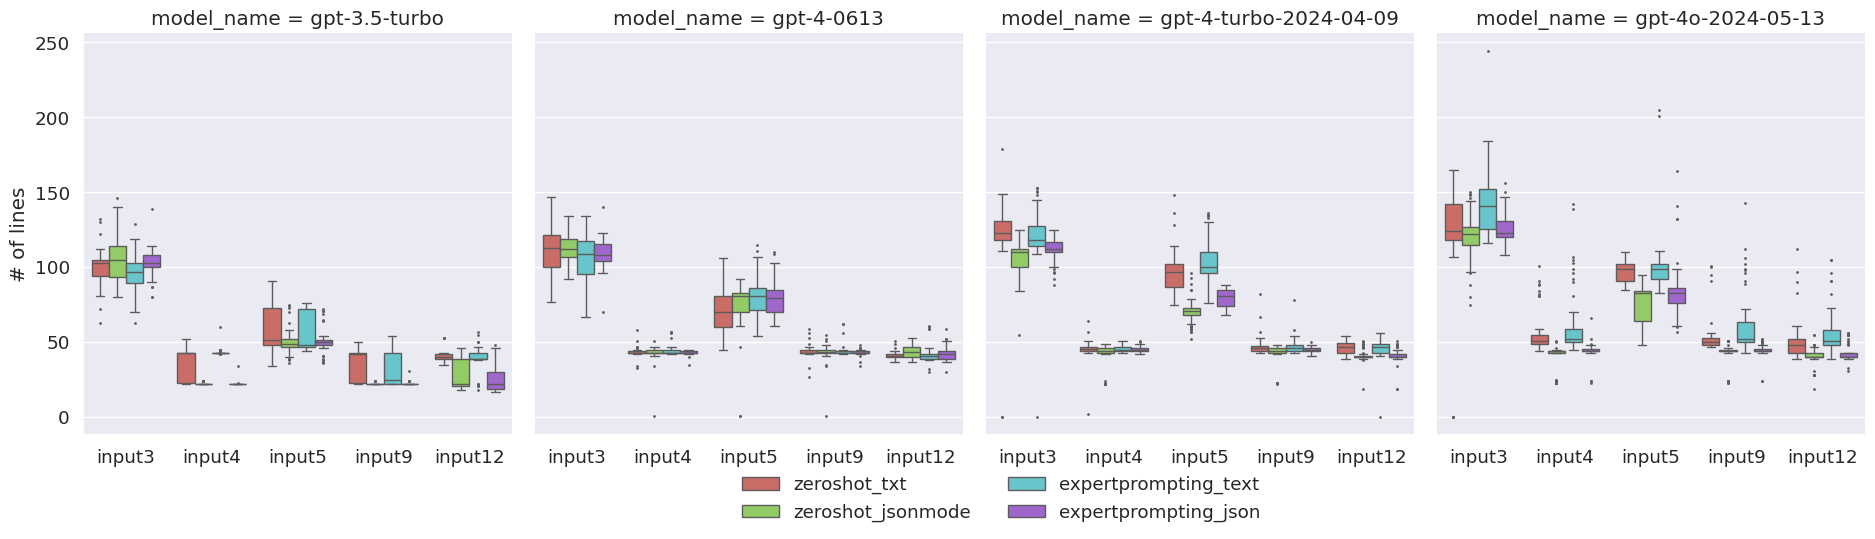

In [118]:
plot_data(
    data=df,
    col_name="model_name",
    plotting_func=sns.boxplot,
    x="input",
    y="lines",
    palette="hls",
    plot_kwargs=dict(fliersize=1),
    hue="method",
    main_title="Eval: Consistency",
    x_label="",
    y_label="# of lines",
    # final=True,
)

表

In [119]:
df = df.convert_dtypes()
df.groupby(["model_name", "input", "method"]).lines.describe()[
    ["mean", "25%", "50%", "75%", "std", "count"]
].style.background_gradient(subset=["std"]).format("{:.1f}")

## eval3: Correctness

In [120]:
# judge関数の結果を, (A)context-groundessが通ったもの (B)consistencyばらつきを除去したもの で比較する
_records = []
for name, _acc in acc:
    for model_name, __acc in _acc.items():
        for meth, dic in __acc.items():
            grades = dic["grade_by_function"]
            sum_judge_all = sum(g.ok for g in grades)

            # A.
            # (1)context-groundnessが通ったもの
            indexes: list[int] = [
                i
                for i, d in enumerate(dic["grade_by_model"]["model_graded"])
                if d.get("decision") == "Y"
            ]

            # (2)judge関数の結果
            js = pd.Series(dic["grade_by_function"])  # [Judgement]

            # (3) (2)を(1)でフィルタしたもの
            filtered: pd.Series = js.loc[indexes]
            sum_judge_only_passed_by_model_grade = sum(j.ok for j in filtered)

            ratio_judge_all = sum_judge_all / N
            ratio_judge_only_passed_by_model_grade = (
                (sum_judge_only_passed_by_model_grade / len(filtered))  # ゼロ割りをケア
                if len(filtered) > 0
                else 0
            )

            # B. 行数のConsistency
            # 四分位範囲（IQR）を使用する. 上限をQ1, 下限をQ3とする
            # (1) 行数を取得
            ll: list[int] = list(
                map(
                    lambda s: len(s.splitlines()),
                    dic["grade_by_model"]["output_parsed"],
                )
            )
            # (2) 分布を計算し上限と下限を取得
            q1 = pd.Series(ll).quantile(0.25)
            q3 = pd.Series(ll).quantile(0.75)

            # (3) 上限と下限に含まれるマニフェストのインデックス
            indexes = [i for i, length in enumerate(ll) if q1 <= length <= q3]
            filtered_by_consistency: pd.Series = js.loc[indexes]
            _sum = sum(j.ok for j in filtered_by_consistency)
            ratio_judge_only_passed_by_consistency = (
                _sum / len(filtered_by_consistency)
                if len(filtered_by_consistency) > 0
                else 0
            )

            # 3.2 dry-run
            dryruns: list = dic["grade_by_dryrun"]
            n_dryrun_pass = sum(j.ok for j in dryruns)
            ratio_dryrun_pass = n_dryrun_pass / len(dryruns)

            _records.extend(
                [
                    dict(
                        input=name,
                        model=model_name,
                        method=meth,
                        # sum_judge_all=sum_judge_all,
                        # sum_judge_only_passed_by_model_grade=sum_judge_only_passed_by_model_grade,
                        ratio_judge_all=ratio_judge_all,
                        ratio_judge_only_passed_by_model_grade=ratio_judge_only_passed_by_model_grade,
                        ratio_judge_only_passed_by_consistency=ratio_judge_only_passed_by_consistency,
                        n_ground=len(filtered),
                        n_consistent=len(filtered_by_consistency),
                        n_dryrun_pass=n_dryrun_pass,
                        ratio_dryrun_pass=ratio_dryrun_pass,
                    )
                ]
            )

df = pd.DataFrame(_records)
df3 = df.melt(
    ["model", "input", "method", "n_ground", "n_consistent", "n_dryrun_pass"],
    var_name="judge_target",
    value_name="r_accept",
)
# df2 = df2.assign(r_accept=df2.n_accept / N)
# df2.round(2).sort_values(["input", "op"])
# df3.sort_values(["model", "input", "method"])

図

/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


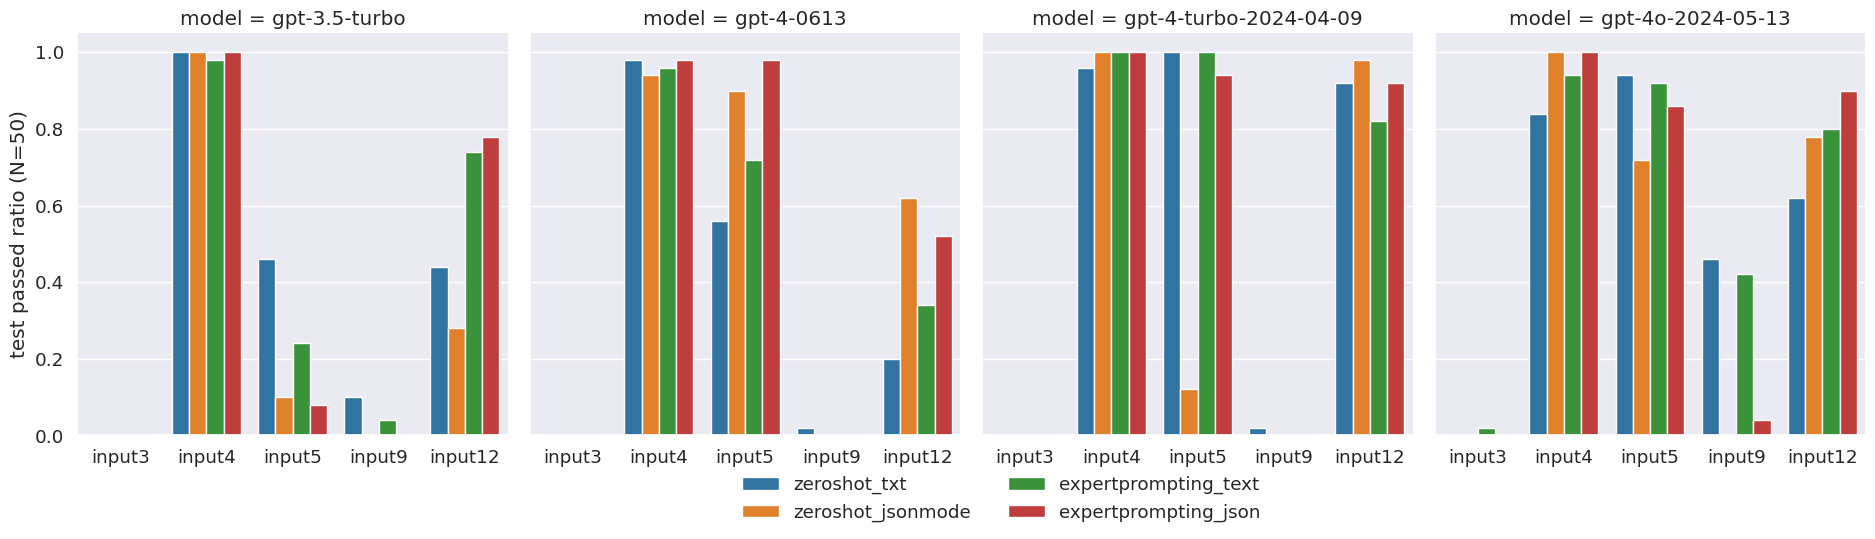

In [121]:
plot_data(
    df3[df3["judge_target"] == "ratio_judge_all"],
    col_name="model",
    x="input",
    y="r_accept",
    hue="method",
    plotting_func=sns.barplot,
    main_title="Eval: Correctness - target=all",
    x_label="",
    y_label=f"test passed ratio (N={N})",
)

In [74]:
df3.head()

,model,input,method,n_ground,n_consistent,n_dryrun_pass,judge_target,r_accept
0,gpt-3.5-turbo,input3,zeroshot_txt,50,31,3,ratio_judge_all,0.0
1,gpt-3.5-turbo,input3,zeroshot_jsonmode,50,29,5,ratio_judge_all,0.0
2,gpt-3.5-turbo,input3,expertprompting_text,50,25,12,ratio_judge_all,0.0
3,gpt-3.5-turbo,input3,expertprompting_json,50,25,1,ratio_judge_all,0.0
4,gpt-4-0613,input3,zeroshot_txt,49,24,39,ratio_judge_all,0.0


In [19]:
df3.model.unique()

array(['gpt-3.5-turbo', 'gpt-4-0613', 'gpt-4-turbo-2024-04-09',
       'gpt-4o-2024-05-13'], dtype=object)

/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


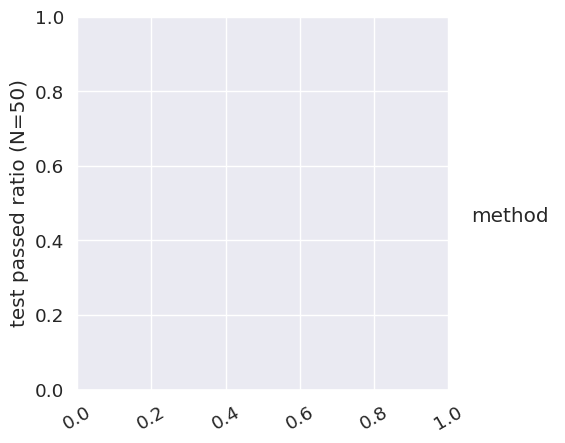

In [20]:
if False:
    # 概要提出用
    sns.set_theme(font_scale=1.2)
    g = plot_data(
        df3[(df3["judge_target"] == "ratio_judge_all") & (df3.model == GPT4_0125)],
        # col_name="model",
        x="input",
        y="r_accept",
        hue="method",
        palette="Set2",
        plotting_func=sns.barplot,
        main_title="",  # f"Eval: Correctness (model={GPT4_0125})",
        x_label="",
        y_label=f"test passed ratio (N={N})",
    )
    g.tick_params(axis="x", rotation=30)
    # sns.move_legend(g, "upper center", bbox_to_anchor=(0.4, 1.2), ncol=1)
    g.savefig("correctness-for-abstract.pdf")

## eval3-2: dry-run

/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


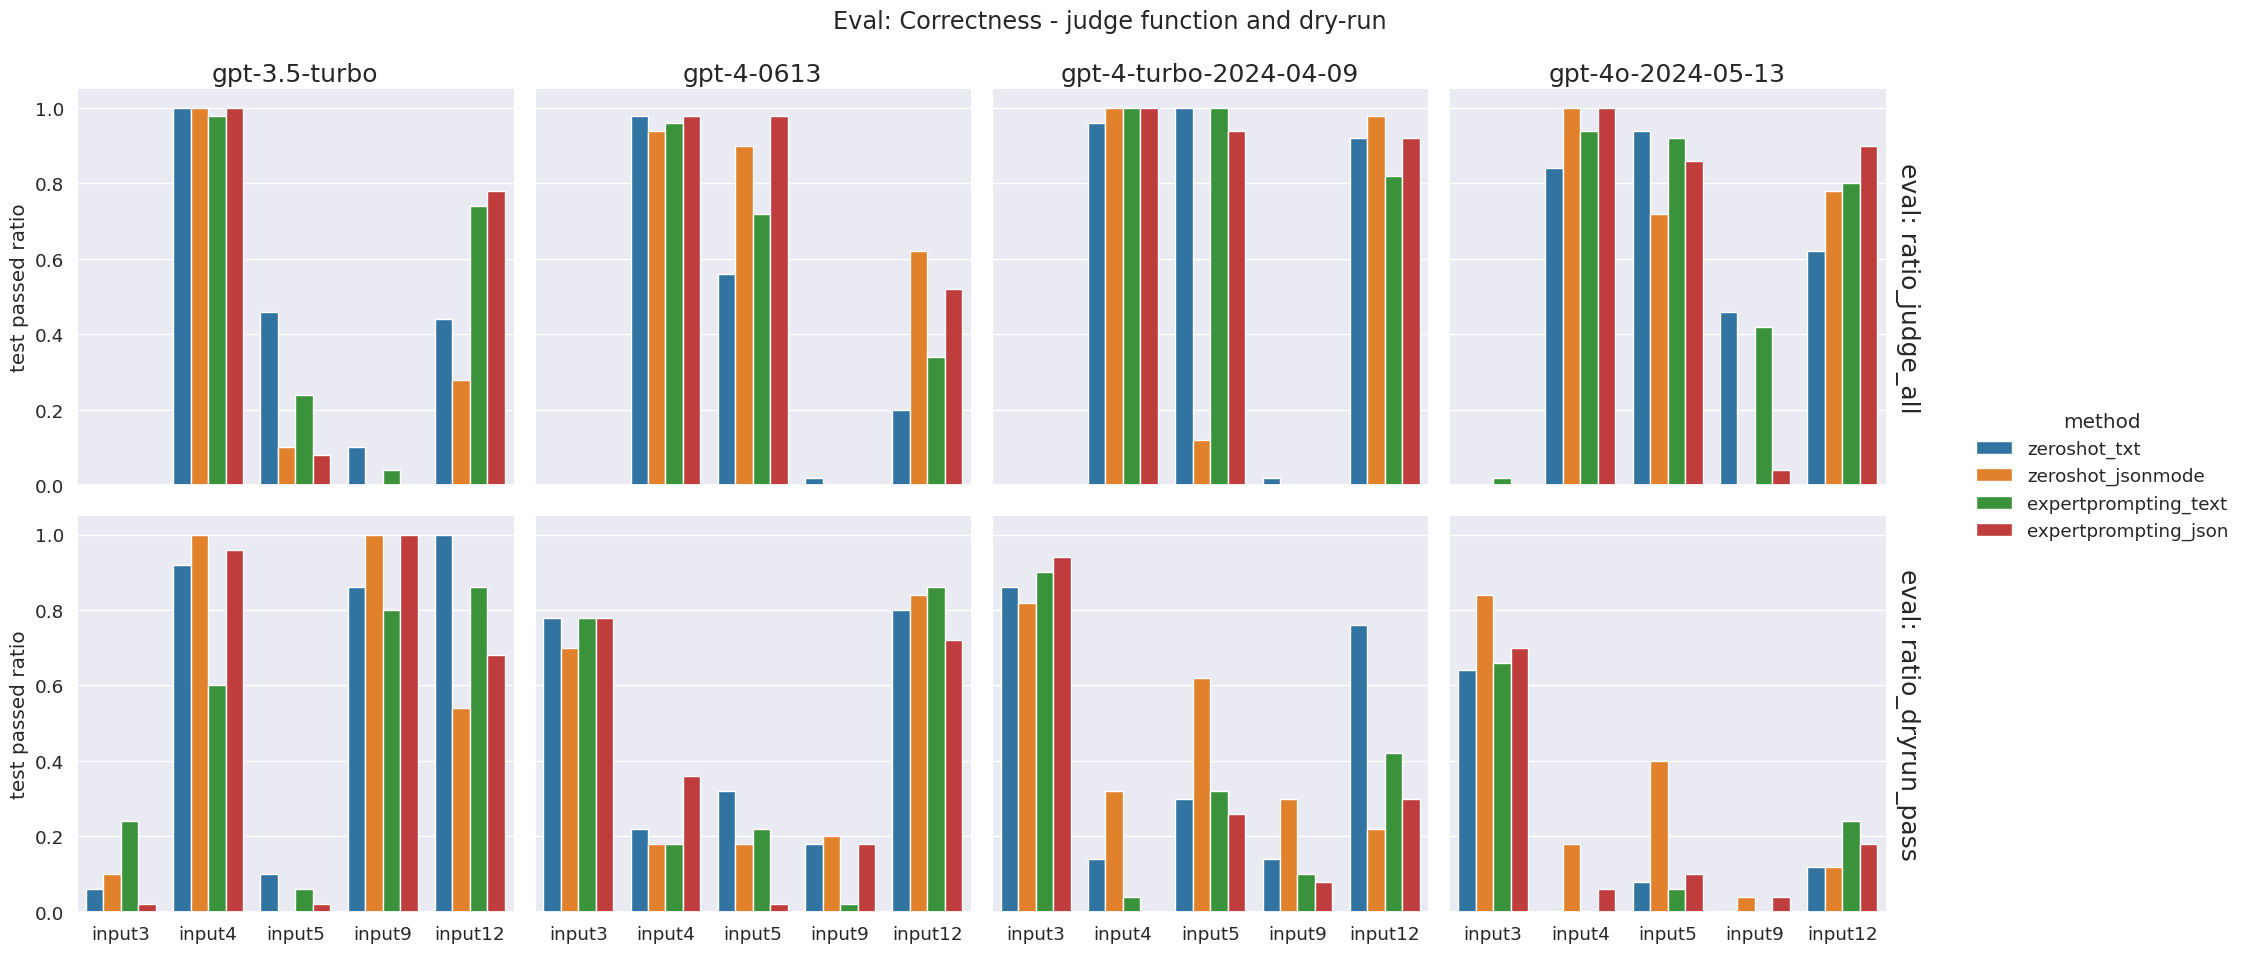

In [21]:
df3_2 = df[["input", "model", "method", "ratio_judge_all", "ratio_dryrun_pass"]]
g = plot_data(
    data=df3_2.melt(id_vars=["input", "model", "method"], var_name="eval_method"),
    x="input",
    y="value",
    hue="method",
    col_name="model",
    row_name="eval_method",
    # plot_kwargs=dict(hue_order=["zeroshot_txt", "zeroshot_jsonmode"]),
    plotting_func=sns.barplot,
    main_title="Eval: Correctness - judge function and dry-run",
    x_label="",
    y_label="test passed ratio",
)
g.set_titles(col_template="{col_name}", row_template="eval: {row_name}", size=18)

## eval3-3: Correctness - filtered

/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/masaru/src/llm4ops/compose2kube/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


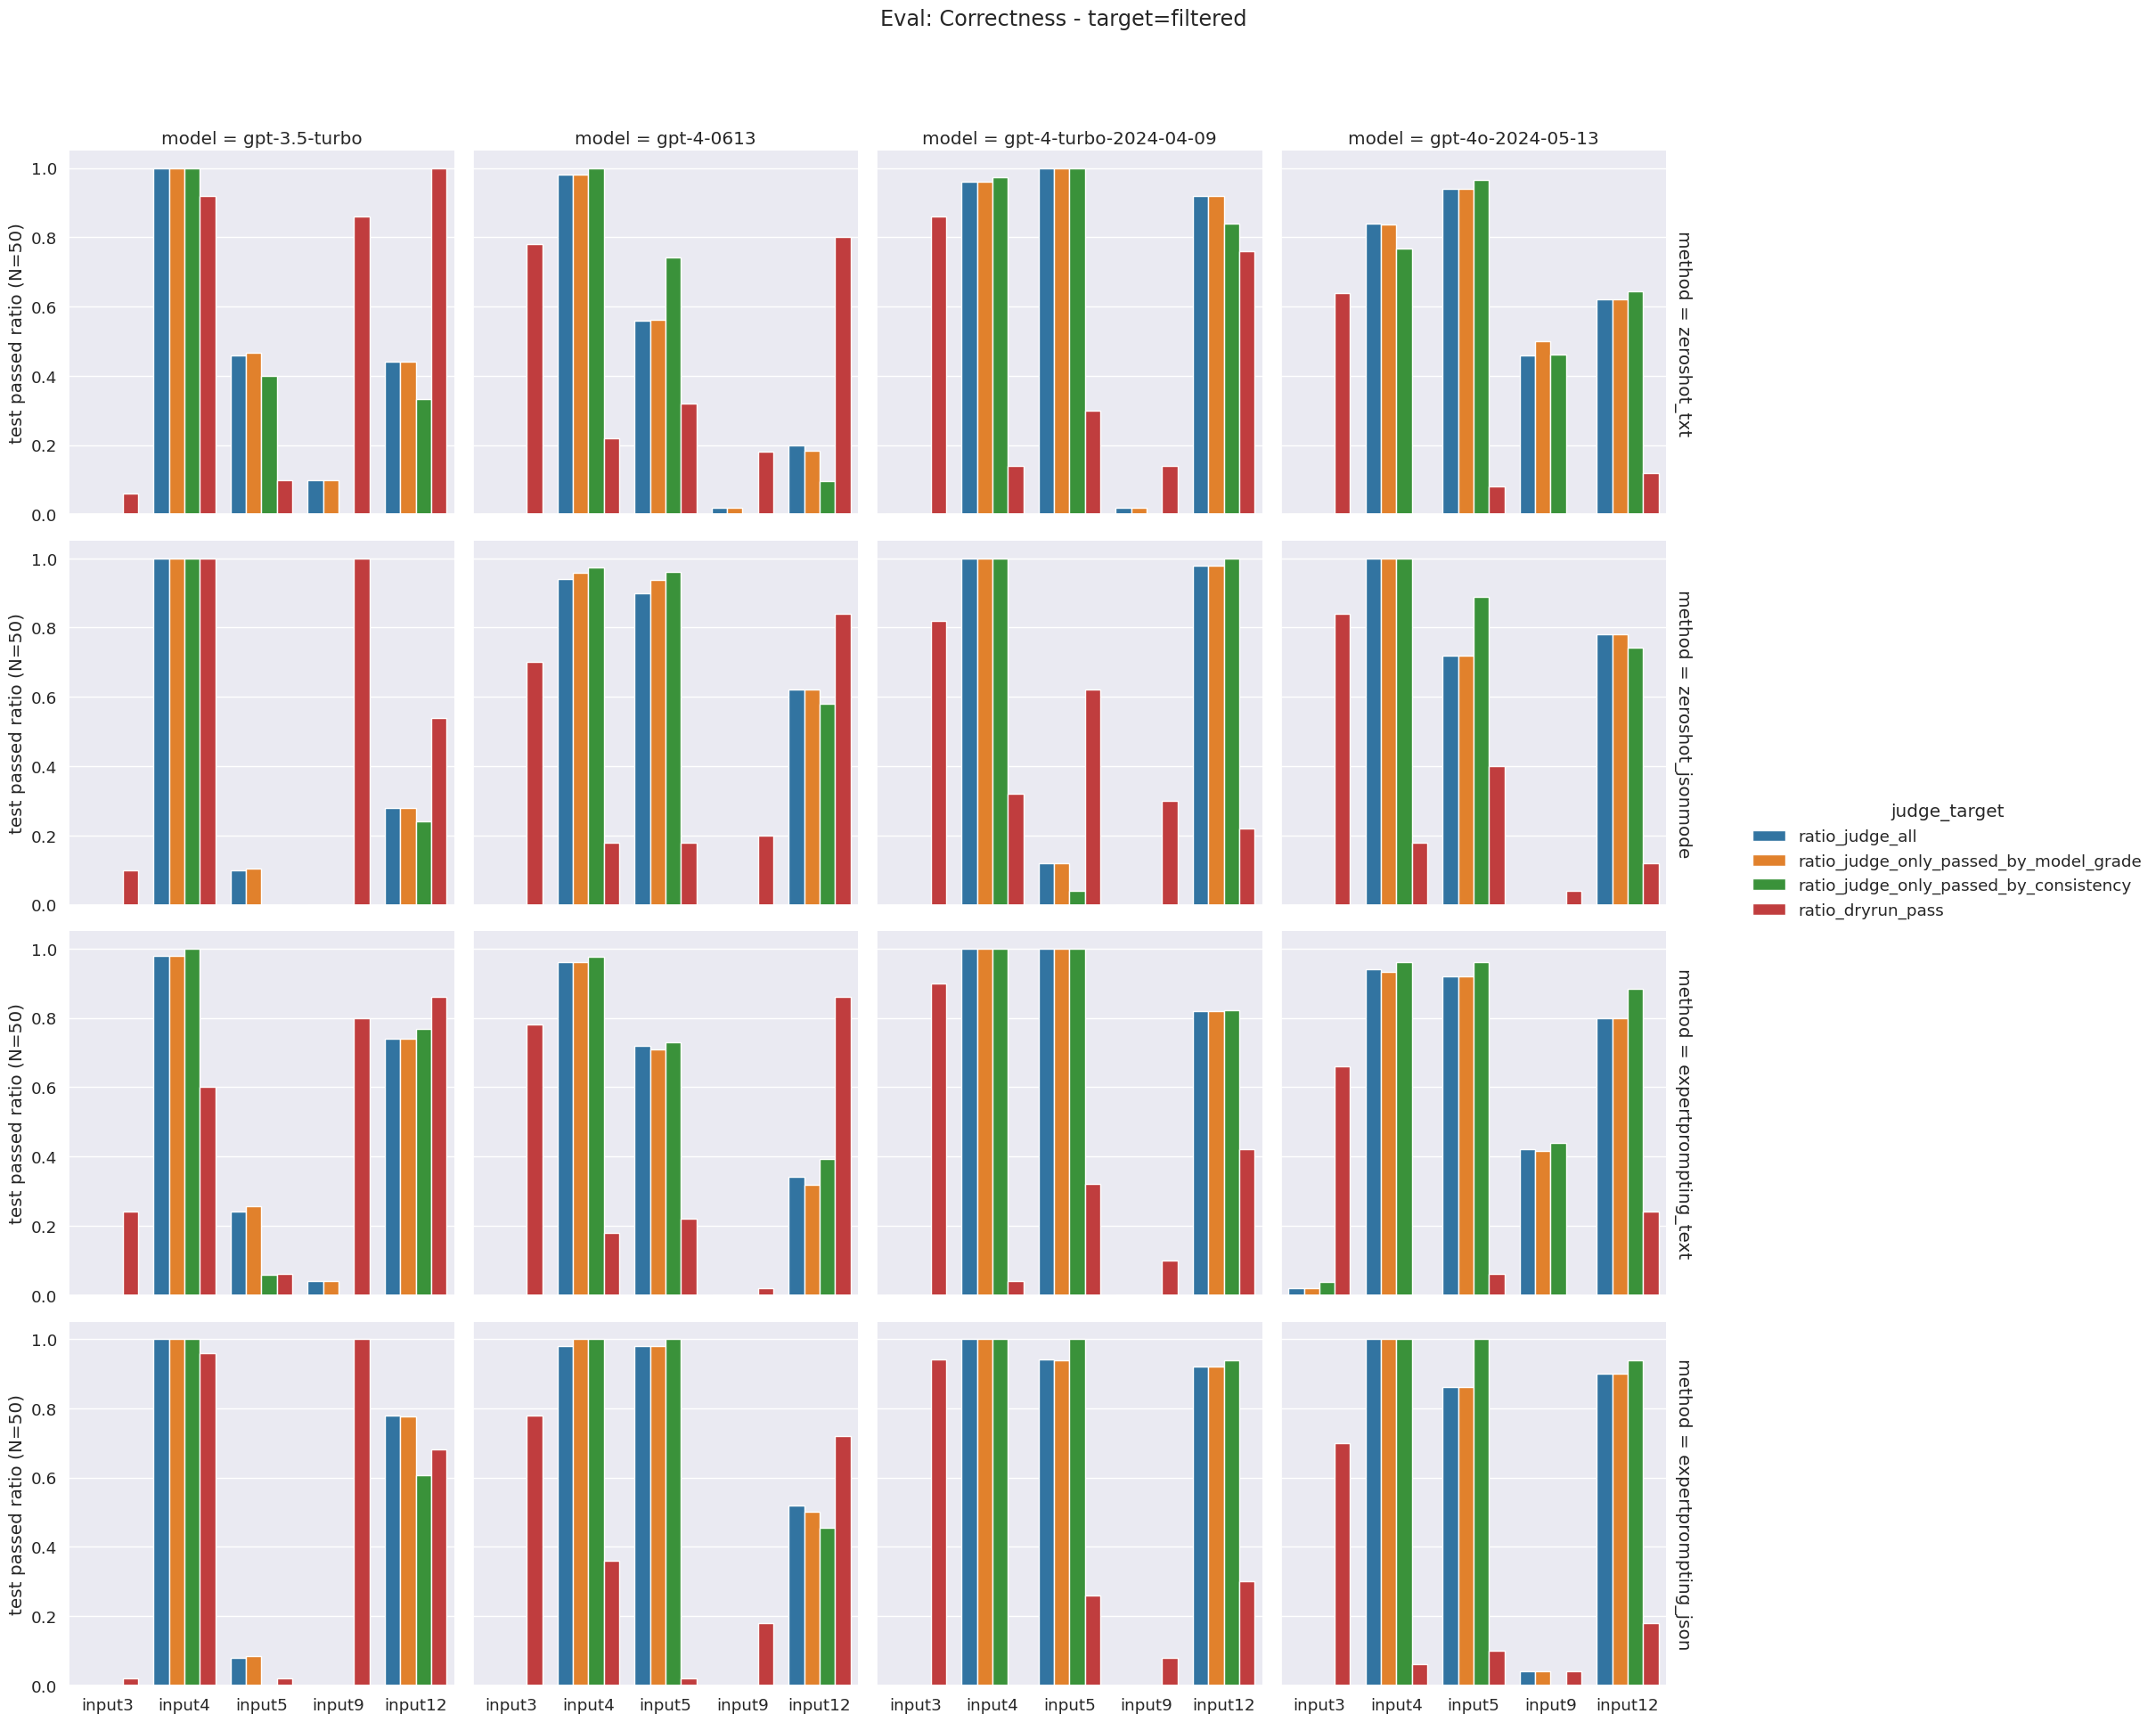

In [22]:
plot_data(
    df3,
    col_name="model",
    row_name="method",
    x="input",
    y="r_accept",
    hue="judge_target",
    plotting_func=sns.barplot,
    main_title="Eval: Correctness - target=filtered",
    x_label="",
    y_label=f"test passed ratio (N={N})",
)